Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [317]:
from random import choices
from random import choices, randint, random, uniform
from functools import reduce
from operator import or_
import lab9_lib
import pprint
import numpy as np
import sys
import matplotlib.pyplot as plt

import lab9_lib

In [318]:
problem_number = 2
fitness = lab9_lib.make_problem(problem_number)
for n in range(10):
    ind = choices([0, 1], k=50)
    print(f"{''.join(str(g) for g in ind)}: {fitness(ind):.2%}")

print(fitness.calls)

10101011011100101101001001110111010101101110111001: 60.00%
11000010111111010100000011100011010100100111000010: 21.80%
11010000001010010000110001110001101010001011010101: 20.00%
11111111010100101011011001111110010110101101011010: 64.00%
01100001011111010001001000100001010110111111011001: 28.00%
00111010000001110111000001110001010101110101111111: 32.00%
01010000001100001001111001010000011000100100110111: 22.40%
00000011101010101011000110101111100000001000010001: 24.60%
01011001010100011000111011000000010011110110001110: 24.00%
00101101011001100000100111111001101101111111010111: 29.20%
10


In [319]:
# CONSTANTS
ghad = 1000
population_size = 2000
offspring_size = 200
kill_size = 200
generations = 50
k = 200  # Parent selection tournament size
s = 10  # Survival selection tournament size
to_kill = 400  # Number to kill in each survival selection
n = 3  # Number of types of crossover (1 to 9)
M = 3  # Number of iterations to change probs
sigma = 0.8 # variance for guassian mutation of probs

fitness_memory = {}
valhala = []
fit_hist = []


population size is: 1800
0.536
population size is: 1800
0.536
population size is: 1800
0.542
population size is: 1800
0.548
population size is: 1800
0.55
population size is: 1800
0.558
population size is: 1800
0.568
population size is: 1800
0.568
population size is: 1800
0.57
population size is: 1800
0.572
population size is: 1800
0.576
population size is: 1800
0.578
population size is: 1800
0.584
population size is: 1800
0.584
population size is: 1800
0.592
population size is: 1800
0.598
population size is: 1800
0.602
population size is: 1800
0.602
population size is: 1800
0.61
population size is: 1800
0.62
population size is: 1800
0.622
population size is: 1800
0.622
population size is: 1800
0.626
population size is: 1800
0.63
population size is: 1800
0.632
population size is: 1800
0.634
population size is: 1800
0.638
population size is: 1800
0.638
population size is: 1800
0.64
population size is: 1800
0.642
population size is: 1800
0.644
population size is: 1800
0.648
population siz

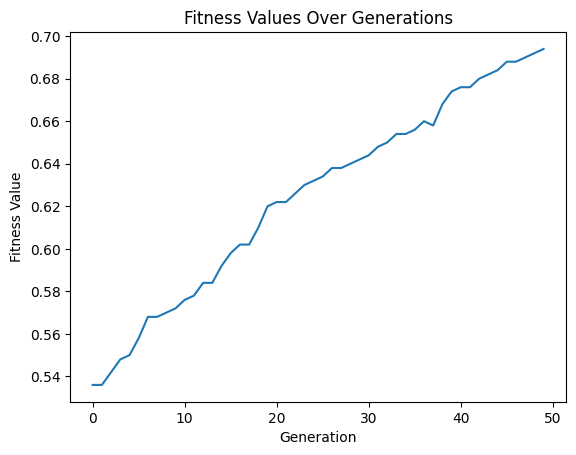

In [320]:
# Renormalize the probability distribution
def renormalize(probs):
    total = sum(probs)
    return [p / total for p in probs]


# Mutate probabilities
def mutate_probs(probs):
    m_index = np.random.choice(len(probs),1)
    probs[m_index[0]] += np.random.normal(0, sigma)
    probs[m_index[0]] = max(probs[m_index[0]] ,0)
    return(renormalize(probs))


# Function to generate the initial population
def generate(population_size):
    '''generate initial population and save their fitness'''
    population = [choices([0, 1], k=ghad) for _ in range(population_size)]
    for ind in population:
        fitness_memory[tuple(ind)] = fitness(ind)
    return population

# Print the individual
def print_individual(*inds):
    for ind in inds:
        print(f"{''.join(str(x) for x in ind)}: \n {get_fitness(ind):.2%}")

# Mutation
def mutate(ind):
    number_bit_mutate = 2
    for _ in range(number_bit_mutate): 
        index = randint(0, len(ind) - 1)  
        ind[index] = 1 - ind[index]  
    return ind

# Uniform crossover
def uniform_crossover(ind1, ind2):
    '''each bit from one parent'''
    return [ind1[i] if i % 2 == 0 else ind2[i] for i in range(len(ind1))]

# OR crossover
def or_crossover(ind1, ind2):
    return [reduce(or_, pair) for pair in zip(ind1, ind2)]

# n-cut crossover function
def n_cut_crossover(ind1, ind2, n):
    '''it cuts the individuals into n slices and take each slice from one indvidual to get the offspring'''
    n = n - 1
    cuts = sorted([randint(1, len(ind1) - 1) for _ in range(n)])
    slices1 = [ind1[i:j] for i, j in zip([0] + cuts, cuts + [None])]
    slices2 = [ind2[i:j] for i, j in zip([0] + cuts, cuts + [None])]
    offspring=[]
    for i in range(n + 1):
        offspring += slices1[i] if i % 2 == 0 else slices2[i]
    return offspring

# call fitness only if not in memory
def get_fitness(ind):
    if tuple(ind) in fitness_memory.keys():
        #print("from memory")
        return fitness_memory[tuple(ind)]
    else:
        #print("calling fitness")
        return fitness(ind)

# print best results
def print_info():
    print(f"maximum fitness achieved for the problem {problem_number} is {max(fit_hist)}")
    print(f"the number of fitness calls for the problem number {problem_number} were {fitness.calls}")


# Main evolutionary loop
########################

probs = [random() for _ in range(3+n)]  # Probabilities for genetic operators
probs = renormalize(probs)

population = generate(population_size)
max_fitness = 0
unchanged_fitness_count = 0

for _ in range(generations):

    for ind in valhala:
        if tuple(ind) not in fitness_memory.keys():
            fitness_memory[tuple(ind)] = fitness(ind)
    population.extend(valhala)
    valhala = []

    # Parent selection and genetic operations
    for _ in range(offspring_size):
        tournament = choices(population, k=k)
        # 0 to n-1
        chosen_operator = np.random.choice(len(probs),1, p=probs)[0]
        best_individual = max(tournament, key=lambda ind: get_fitness(ind))
        valhala.append(best_individual)

        if chosen_operator == 0:  # Mutation
            best_individual = max(tournament, key=lambda ind: get_fitness(ind))
            offspring = [mutate(best_individual)]
        else:  # Crossover
            best_individuals = sorted(tournament, key=lambda ind: get_fitness(ind), reverse=True)[:2]
            if chosen_operator == 1:
                offspring = [uniform_crossover(*best_individuals)]
            elif chosen_operator == 2:
                offspring = [or_crossover(*best_individuals)]
            else:
                offspring = [n_cut_crossover(*best_individuals, chosen_operator - 1)]
        # Add offspring to the pool
        for ind in offspring:
            if tuple(ind) not in fitness_memory.keys():
                fitness_memory[tuple(ind)] = fitness(ind)
        population.extend(offspring)



    #Survival selection
    #for _ in range(int(kill_size/to_kill)):
        #'''in each rounds does a tournoment and remove worsts of the tournoument'''
        # tournament = choices(population, k=s)
        # tournament_fitness = [(ind,get_fitness(ind)) for ind in tournament]
        # to_remove = sorted(tournament_fitness, key=lambda x: x[1])[:to_kill]
        # population = [ind for ind in population if tuple(ind) not in {tuple(tr[0]) for tr in to_remove}]


    pop_fitness = [(ind,get_fitness(ind)) for ind in population]
    to_keep = sorted(pop_fitness, key=lambda x: x[1])[to_kill:]
    population = [ind[0] for ind in to_keep]
    print(f"population size is: {len(population)}")


    # Checking fitness improvement
    current_max = max([get_fitness(ind) for ind in population])
    fit_hist.append(current_max)
    print(current_max)
    if current_max == 1:
        break
    if current_max > max_fitness:
        max_fitness = current_max
        unchanged_fitness_count = 0
    else:
        unchanged_fitness_count += 1

    if unchanged_fitness_count >= M:
        probs = mutate_probs(probs)
        print(f"current max is stall at {current_max} ... updating probabilities!")
        unchanged_fitness_count = 0





print_info()
plt.plot(fit_hist)
plt.title("Fitness Values Over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.show()



